## Importing all needed libraries and kits

In [2]:
import numpy as np
import pandas as pd

# Generating fingerprints
from rdkit import Chem
from rdkit.Chem import AllChem

#PCA
from sklearn.decomposition import PCA

#Visualisation
import seaborn as sns
import matplotlib.pylab as plt

#Splitting data into train and test
from sklearn.model_selection import train_test_split

#Removing variance
from sklearn.feature_selection import VarianceThreshold

#Cross validation
from sklearn.model_selection import StratifiedKFold, cross_val_score
import statistics

# confusion matrix, AUC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#Random Forest
from sklearn.ensemble import RandomForestClassifier

RDKit WARNING: [12:25:54] Enabling RDKit 2019.09.3 jupyter extensions


# Generating Morgan Fingerprints of 1024-bits

In [3]:
df = pd.read_csv("final_df_smiles.csv", encoding = "ISO-8859-1")
df.head()

,Standardised_Smiles,Target
0,Oc1c(Cl)cc(Cl)cc1Sc1cc(Cl)cc(Cl)c1O,0
1,CCCCCC1C(=O)CCC1CC(=O)O,0
2,Cc1cc(=O)n(-c2ccccc2)n1C,0
3,O=C(C=CC=Cc1ccc2c(c1)OCO2)N1CCCCC1,0
4,O=c1ccc2cc(OC3OC(CO)C(O)C(O)C3O)c(O)cc2o1,0


In [4]:
# generation of morgan fingerprints with 1024 bit length
morgan1024 = []

for i in range (0,len(df)):
    mol = Chem.MolFromSmiles(df.iloc[i,0])
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    fp_list = np.unique(fp, return_inverse = True)[1].tolist()
    morgan1024.append(fp_list)

In [5]:
morgan1024 = pd.DataFrame(data= morgan1024)
morgan1024 = pd.concat([morgan1024, df.iloc[:, -1]], axis = 1)
display(morgan1024.head())

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,Target
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [6]:
# showing the number of compounds where target = 0 and target = 1
print("Inactive Compounds:{}".format(morgan1024[(morgan1024["Target"]==0)].shape[0]))
print("Active Compounds:{}".format(morgan1024[(morgan1024["Target"]==1)].shape[0]))

Inactive Compounds:1126
Active Compounds:304


In [7]:
# creating the X and y variables, where X = features and y = target (1 or 0)
X1 = morgan1024.iloc[:, :-1] #X = all rows and columns except the last column
y1 = morgan1024.iloc[:, -1] #y = only the last column (target)

# Chemical Space Visualisation 1024-bits

In [8]:
# proinciple component analysis, reducing 1024 features to 2 (PC1 and PC2)

pca = PCA(n_components = 2)
print(X1.shape)
res = pca.fit_transform(X1)
print(res.shape)

(1430, 1024)
(1430, 2)


In [9]:
# creating a dataframe with PC1 and PC2 as the features

principle = pd.DataFrame(data = res, columns = ['PC1', 'PC2'])
principle.head()

,PC1,PC2
0,-0.448732,-0.699196
1,-0.830436,0.879232
2,0.699840,-0.864198
3,0.513773,0.124667
4,0.010172,1.683023


In [10]:
# adding 'Target' columns to dataframe

FinalPCA = pd.concat([principle, morgan1024[['Target']]], axis = 1)
FinalPCA.head()

,PC1,PC2,Target
0,-0.448732,-0.699196,0
1,-0.830436,0.879232,0
2,0.699840,-0.864198,0
3,0.513773,0.124667,0
4,0.010172,1.683023,0


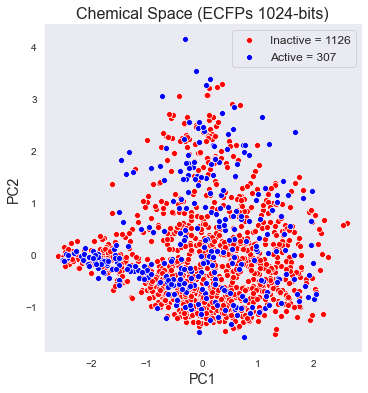

In [11]:
# visualising PC1 vs PC2

sns.set_style('dark')

colours = 'red', 'blue'
ax = sns.pairplot(data = FinalPCA, hue = 'Target', x_vars = ['PC1'], y_vars = ['PC2'], palette = colours, height = 5)

plt.xlabel('PC1', fontsize = 14)
plt.ylabel('PC2', fontsize = 14)
plt.title('Chemical Space (ECFPs 1024-bits)', fontsize = 16)
ax._legend.remove()
plt.legend(['Inactive = 1126','Active = 307'], fontsize = 12)

# Data Pre-Processing (1024-bit)

In [12]:
# splitting 1024-bit database in 20% test set and 80% training set

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, random_state = 1)
print('X1_train: {}'.format(X1_train.shape))
print('y1_train: {}'.format(y1_train.shape))
print()
print('X1_test: {}'.format(X1_test.shape))
print('y1_test: {}'.format(y1_test.shape))

X1_train: (1144, 1024)
y1_train: (1144,)

X1_test: (286, 1024)
y1_test: (286,)


In [13]:
# removing features with low variance

def get_variance(df, threshold):
    sel = VarianceThreshold(threshold = (threshold))
    var = pd.DataFrame(data = sel.fit_transform(df))
    features = sel.get_support(indices = True)
    var.columns = features
    return (var)

In [14]:
# creating subdatabases with a variance of 0%, 5% and 10%

X1_var_0 = get_variance(X1_train, 1*(1-1))
X1_var_5 = get_variance(X1_train, 0.95*(1-0.95))
X1_var_10 = get_variance(X1_train, 0.90*(1-0.90))

print('Features with 0% variance: {}'.format(X1_var_0.shape))
print('Features with 5% variance: {}'.format(X1_var_5.shape))
print('Features with 10% variance: {}'.format(X1_var_10.shape))

Features with 0% variance: (1144, 1024)
Features with 5% variance: (1144, 137)
Features with 10% variance: (1144, 55)


# Feature Selection 1024-bit

In [15]:
# cross validation comparing the performances of X_var_0, X_var_5 and X_var_10 on the training set

def cross_val (num_splits, n_estimators, X, y, random_seed):
    sfk = StratifiedKFold(n_splits = num_splits, shuffle = True, random_state = random_seed)
    rf = RandomForestClassifier(n_estimators = n_estimators, random_state = random_seed)
    rf_cv_score = cross_val_score(rf, X, y, cv = sfk, scoring = 'roc_auc')
    
    return (statistics.median(rf_cv_score), statistics.stdev(rf_cv_score))

In [16]:
# creating a list of feature selection values forX_var_0, X_var_5 and X_var_10

feature_selection = []
for subdatabase in (X1_var_0, X1_var_5, X1_var_10):
    feature_selection.append(cross_val(10, 100, subdatabase , y1_train, 1))

In [17]:
# converting list into a comprehendable dataframe

feature_selection_df = pd.DataFrame(data = feature_selection, index=['X1_var_0', 'X1_var_5', 'X1_var_10'])
feature_selection_df = feature_selection_df.round(decimals=3)*100
feature_selection_df.columns = ["Median AUC score (%)", "Standard Deviation"]
display(feature_selection_df)

,Median AUC score (%),Standard Deviation
X1_var_0,75.1,6.5
X1_var_5,76.9,4.6
X1_var_10,76.1,5.4


# Model Performance on test set

In [18]:
# select features with best performance on train set, in this case X_var_95
best_features = X1_var_5

# select the same features for the test set as X_var_95
columns_name= best_features.columns
X1_test_features = X1_test[columns_name[:]]
display(X1_test_features.head())
print(X1_test_features.shape)

,1,3,4,13,15,25,33,36,42,64,...,926,927,932,935,946,967,974,1009,1017,1019
951,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1059,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1269,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,0,0,0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
942,0,0,0,0,1,0,1,0,0,1,...,1,0,0,1,0,0,0,0,0,1


(286, 137)


In [23]:
df1 = pd.DataFrame(best_features)
df1.head()

,1,3,4,13,15,25,33,36,42,64,...,926,927,932,935,946,967,974,1009,1017,1019
0,0,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,1,1,0,0,...,1,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [19]:
# apply rf to obtain performance of best feature combination on test set
rf = RandomForestClassifier(n_estimators = 100, random_state= 1)
rf.fit(best_features, y1_train)

#make predictions
y1_score = rf.predict(X1_test_features)
y1_pred_proba = rf.predict_proba(X1_test_features)[::,1]

# calculate performance matrices
print("=== Confusion Matrix ===")
CM = confusion_matrix(y1_test, y1_score)
print(CM)
print('\n')
print("=== Classification Report ===")
print(classification_report(y1_test, y1_score))
print('\n')
print("=== AUC Score ===")
print(roc_auc_score(y1_test, y1_pred_proba))

=== Confusion Matrix ===
[[225   9]
 [ 32  20]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       234
           1       0.69      0.38      0.49        52

    accuracy                           0.86       286
   macro avg       0.78      0.67      0.71       286
weighted avg       0.84      0.86      0.84       286



=== AUC Score ===
0.7862836949375411


In [20]:
# apply rf algorithm to rank the features based on their importance
feature_imp = pd.Series(rf.feature_importances_,index=columns_name).sort_values(ascending=False)
feature_imp.head(10)

694     0.018266
147     0.016954
389     0.016936
80      0.016851
935     0.016042
656     0.015966
314     0.014879
33      0.014746
578     0.013639
1017    0.013317
dtype: float64